In [75]:
using LCIO
#using GRUtils
using FastJet
using CxxWrap: StdVector
using LinearAlgebra
using StatsPlots

In [76]:
#originally from Chester's code - thanks!
function invMassSum(particle_1, particle_2)
    a = sqrt((getEnergy(particle_1)+getEnergy(particle_2))^2-
        dot(getMomentum(particle_1)+getMomentum(particle_2),
            getMomentum(particle_1)+getMomentum(particle_2)))
    return a
end


#originally from Chester's code - thanks!
function zMuonIndices(data, threshold)
    
    iParticle = 0
    posMuonList = []
    negMuonList = []
    for particle in getCollection(data, "MCParticle")
        iParticle += 1
        if abs(getPDG(particle))==13 && getGeneratorStatus(particle)==1
            if getCharge(particle)==1
                push!(posMuonList, [particle, iParticle])
            elseif getCharge(particle)==-1
                push!(negMuonList, [particle, iParticle])
            end
        end
    end
    
    candidatePair=[]
    
    candidateDiff=91.187
    for item_pos in posMuonList    
        posParticle = item_pos[1]
        for item_neg in negMuonList
            negParticle = item_neg[1]
            if abs(91.187-invMassSum(posParticle, negParticle))<abs(candidateDiff)
                candidateDiff=91.187-invMassSum(posParticle, negParticle)
                candidatePair=[item_pos, item_neg]
            end
        end
    end
    
    indices = [candidatePair[1][2], candidatePair[2][2]]
    if abs(candidateDiff)>threshold
        indices=[0,0]
    end
    return indices
end



zMuonIndices (generic function with 1 method)

In [77]:
# simple histograms
jetMassList = Float64[]
nJetList = Float64[]
nParticleList = Float64[]
jetMomentum = Float64[]

# We are setting up the jet algorithm
# for details, see "A new jet reconstruction algorithm for lepton colliders"
# https://arxiv.org/abs/1404.4294
vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)



LCIO.open("E250-TDR_ws.Pe2e2h_ss.Gwhizard-2_82.eR.pL.slcio") do reader
    iEvent = 0
    for event in reader
        iEvent += 1
        iParticle = 0
        iMuon = 0
        particles = PseudoJet[]
        MuonIndices = zMuonIndices(event,10)
        for particle in getCollection(event, "MCParticle")
            iParticle += 1
            
            if getGeneratorStatus(particle) != 1 || iParticle in MuonIndices || (abs(getPDG(particle))== 12 || abs(getPDG(particle))==14 || abs(getPDG(particle))==16) 
                continue
            end
            E = getEnergy(particle)
            p = getMomentum(particle)
            #FastJet doesn't operate on LCIO particles, unfortunately. It wants its own input format.
            x = PseudoJet(p[1], p[2], p[3], E)
            push!(particles, x)
            FastJet.set_user_index(x, iParticle)
        end
        # after preparing the input, we can run the tool
        cs = ClusterSequence(StdVector(particles), jet_def)
        # We want 4 jets. Ideally, we'll have one muon from the Z each in two of the jets
        # and particles corresponding to the strange quarks in the other two.
        # This is the lazy way to do the reconstruction.
        # A better way is to find the muons from the Z _first_, and then hand the rest to the jet finder.
        jets = exclusive_jets(cs, 2)
        push!(nJetList, length(jets))
        for j in jets
            # this is just for demonstration how to figure out what particles are in which jet
            # we have forced the event into four jets, so if we don't get back exactly 4 here, something wrong.
            push!(nParticleList, length(constituents(j)))
            push!(jetMomentum, sqrt(FastJet.modp2(j)))
            @assert FastJet.n_particles(cs) == length(particles)
        end
    end
    println("read ", iEvent, " events")
    println(length(jetMomentum))
end
#println(nJetList)
#histogram(nJetList)
#savefig("nJets.pdf")
println("here")

#savefig("nParticles.pdf")




read 100000 events
200000
here


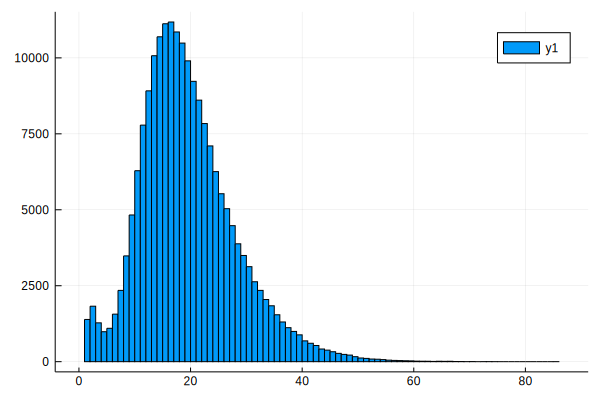

In [78]:
histogram(nParticleList, nbins=100)

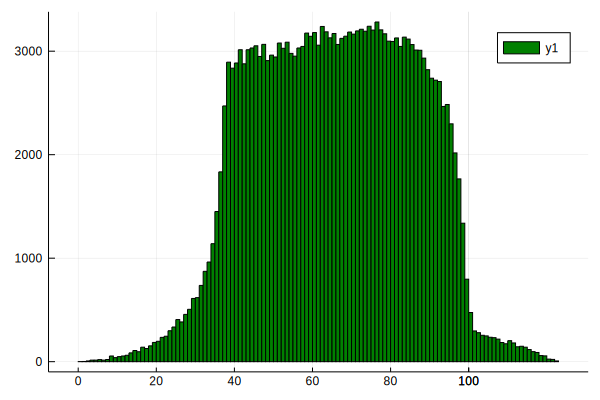

In [79]:
histogram(jetMomentum, nbins=125, colour=[:green])

In [80]:
# simple histograms - gg
jetMassList = Float64[]
nJetList = Float64[]
nParticleListgg = Float64[]
jetMomentumgg = Float64[]
strangeindices = Int[]
# We are setting up the jet algorithm
# for details, see "A new jet reconstruction algorithm for lepton colliders"
# https://arxiv.org/abs/1404.4294
vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)



LCIO.open("E250-TDR_ws.Pmumuh2gg.Gwhizard-2_11.eL.pR.slcio") do reader
    iEvent = 0
    for event in reader
        iEvent += 1
        iParticle = 0
        iMuon = 0
        strangeindices = Int[]
        particles = PseudoJet[]
        MuonIndices = zMuonIndices(event,10)
        for particle in getCollection(event, "MCParticle")
            iParticle += 1
            pdg1 = getPDG(particle)
            if getGeneratorStatus(particle) != 1 || iParticle in MuonIndices || (abs(getPDG(particle))== 12 || abs(getPDG(particle))==14 || abs(getPDG(particle))==16) 
                continue
            end
            if pdg1==130 ||(pdg1>299 && pdg1<400)
                push!(strangeindices, iParticle)
            end
            E = getEnergy(particle)
            p = getMomentum(particle)
            #FastJet doesn't operate on LCIO particles, unfortunately. It wants its own input format.
            x = PseudoJet(p[1], p[2], p[3], E)
            push!(particles, x)
            FastJet.set_user_index(x, iParticle)
        end
        # after preparing the input, we can run the tool
        cs = ClusterSequence(StdVector(particles), jet_def)
        # We want 4 jets. Ideally, we'll have one muon from the Z each in two of the jets
        # and particles corresponding to the strange quarks in the other two.
        # This is the lazy way to do the reconstruction.
        # A better way is to find the muons from the Z _first_, and then hand the rest to the jet finder.
        jets = exclusive_jets(cs, 2)
        push!(nJetList, length(jets))
        for j in jets
            # this is just for demonstration how to figure out what particles are in which jet
            # we have forced the event into four jets, so if we don't get back exactly 4 here, something wrong.
            push!(nParticleListgg, length(constituents(j)))
           
                
                    
                    push!(jetMomentumgg, sqrt(FastJet.modp2(j)))
                    
                @assert FastJet.n_particles(cs) == length(particles)
            
        end
    end
    println("read ", iEvent, " events")
    println(length(jetMomentumgg))
end
#println(nJetList)
#histogram(nJetList)
#savefig("nJets.pdf")


#savefig("nParticles.pdf")





read 100000 events
200000


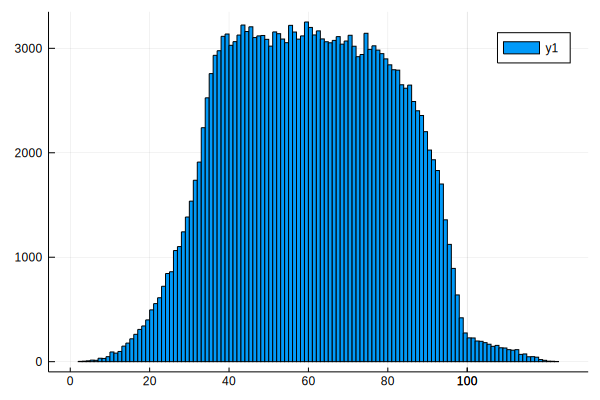

In [81]:
histogram(jetMomentumgg, nbins=125)

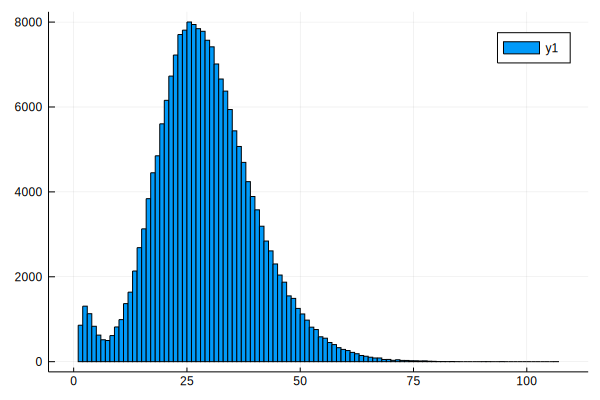

In [82]:
histogram(nParticleListgg, nbins=100)

In [83]:
# simple histograms - cc
jetMassList = Float64[]
nJetList = Float64[]
nParticleListcc = Float64[]
jetMomentumcc = Float64[]
strangeindices = Int[]
# We are setting up the jet algorithm
# for details, see "A new jet reconstruction algorithm for lepton colliders"
# https://arxiv.org/abs/1404.4294
vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)



LCIO.open("E250-TDR_ws.Pmumuh2cc.Gwhizard-2_11.eL.pR.slcio") do reader
    iEvent = 0
    for event in reader
        iEvent += 1
        iParticle = 0
        iMuon = 0
        strangeindices = Int[]
        particles = PseudoJet[]
        MuonIndices = zMuonIndices(event,10)
        for particle in getCollection(event, "MCParticle")
            iParticle += 1
            pdg1 = getPDG(particle)
            if getGeneratorStatus(particle) != 1 || iParticle in MuonIndices || (abs(getPDG(particle))== 12 || abs(getPDG(particle))==14 || abs(getPDG(particle))==16) 
                continue
            end
            if pdg1==130 ||(pdg1>299 && pdg1<400)
                push!(strangeindices, iParticle)
            end
            E = getEnergy(particle)
            p = getMomentum(particle)
            #FastJet doesn't operate on LCIO particles, unfortunately. It wants its own input format.
            x = PseudoJet(p[1], p[2], p[3], E)
            push!(particles, x)
            FastJet.set_user_index(x, iParticle)
        end
        # after preparing the input, we can run the tool
        cs = ClusterSequence(StdVector(particles), jet_def)
        # We want 4 jets. Ideally, we'll have one muon from the Z each in two of the jets
        # and particles corresponding to the strange quarks in the other two.
        # This is the lazy way to do the reconstruction.
        # A better way is to find the muons from the Z _first_, and then hand the rest to the jet finder.
        jets = exclusive_jets(cs, 2)
        push!(nJetList, length(jets))
        for j in jets
            # this is just for demonstration how to figure out what particles are in which jet
            # we have forced the event into four jets, so if we don't get back exactly 4 here, something wrong.
            push!(nParticleListcc, length(constituents(j)))
            
               
                    push!(jetMomentumcc, sqrt(FastJet.modp2(j)))
                    
                    
                    @assert FastJet.n_particles(cs) == length(particles)
               
          
        end
        
    end
    println("read ", iEvent, " events")
    println(length(jetMomentumcc))
end
#println(nJetList)
#histogram(nJetList)
#savefig("nJets.pdf")


#savefig("nParticles.pdf")






read 100000 events
200000


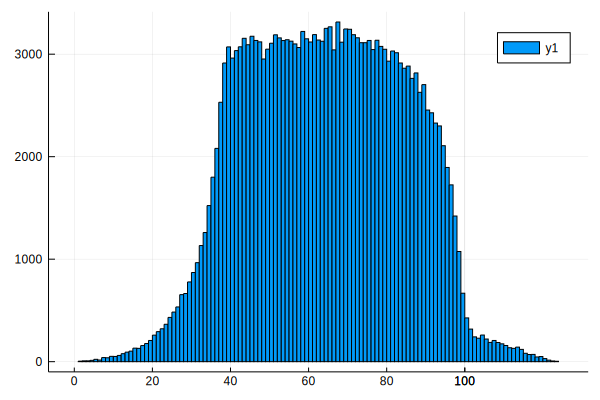

In [84]:
histogram(jetMomentumcc, nbins=125)

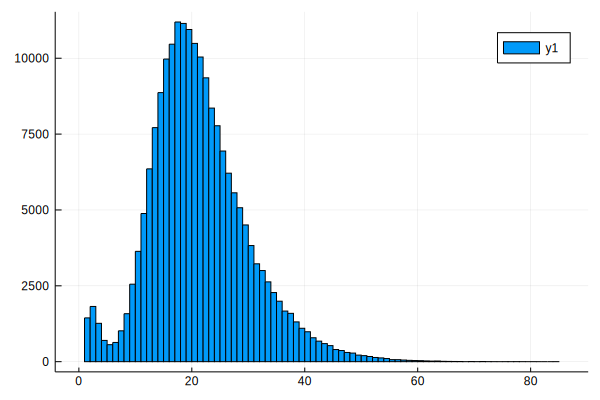

In [85]:
histogram(nParticleListcc, nbins=100)

In [86]:
# simple histograms - bb
jetMassList = Float64[]
nJetList = Float64[]
nParticleListbb = Float64[]
jetMomentumbb = Float64[]
strangeindices = Int[]
# We are setting up the jet algorithm
# for details, see "A new jet reconstruction algorithm for lepton colliders"
# https://arxiv.org/abs/1404.4294
vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)



LCIO.open("E250-TDR_ws.Pmumuh2bb.Gwhizard-2_11.eL.pR.slcio") do reader
    iEvent = 0
    for event in reader
        iEvent += 1
        iParticle = 0
        iMuon = 0
        strangeindices = Int[]
        particles = PseudoJet[]
        MuonIndices = zMuonIndices(event,10)
        for particle in getCollection(event, "MCParticle")
            iParticle += 1
            pdg1 = getPDG(particle)
            if getGeneratorStatus(particle) != 1 || iParticle in MuonIndices || (abs(getPDG(particle))== 12 || abs(getPDG(particle))==14 || abs(getPDG(particle))==16) 
                continue
            end
            if pdg1==130 ||(pdg1>299 && pdg1<400)
                push!(strangeindices, iParticle)
            end
            E = getEnergy(particle)
            p = getMomentum(particle)
            #FastJet doesn't operate on LCIO particles, unfortunately. It wants its own input format.
            x = PseudoJet(p[1], p[2], p[3], E)
            push!(particles, x)
            FastJet.set_user_index(x, iParticle)
        end
        # after preparing the input, we can run the tool
        cs = ClusterSequence(StdVector(particles), jet_def)
        # We want 4 jets. Ideally, we'll have one muon from the Z each in two of the jets
        # and particles corresponding to the strange quarks in the other two.
        # This is the lazy way to do the reconstruction.
        # A better way is to find the muons from the Z _first_, and then hand the rest to the jet finder.
        jets = exclusive_jets(cs, 2)
        push!(nJetList, length(jets))
        for j in jets
            # this is just for demonstration how to figure out what particles are in which jet
            # we have forced the event into four jets, so if we don't get back exactly 4 here, something wrong.
            push!(nParticleListbb, length(constituents(j)))
            
                
                    push!(jetMomentumbb, sqrt(FastJet.modp2(j)))
                    
                    
                    @assert FastJet.n_particles(cs) == length(particles)
                
            
        end
    end
    println("read ", iEvent, " events")
    println(length(jetMomentumbb))
end
#println(nJetList)
#histogram(nJetList)
#savefig("nJets.pdf")


#savefig("nParticles.pdf")







read 100000 events
200000


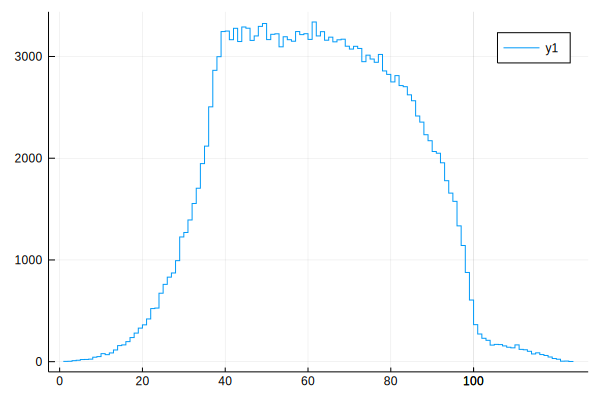

In [87]:
plot(jetMomentumbb, seriestype=:stephist)

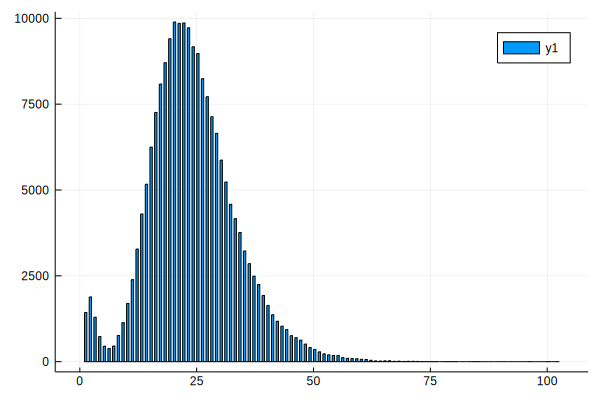

In [88]:
histogram(nParticleListbb )

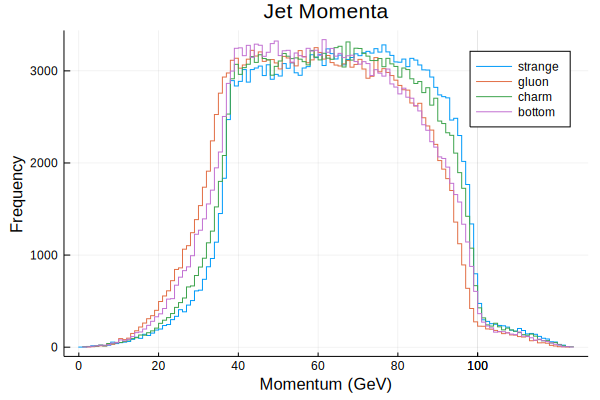

In [89]:
plot([jetMomentum,jetMomentumgg, jetMomentumcc, jetMomentumbb], nbins=125,
    seriestype=:stephist, title = "Jet Momenta", 
    xlabel = "Momentum (GeV)", ylabel = "Frequency", 
    label = ["strange" "gluon" "charm" "bottom"]
    )

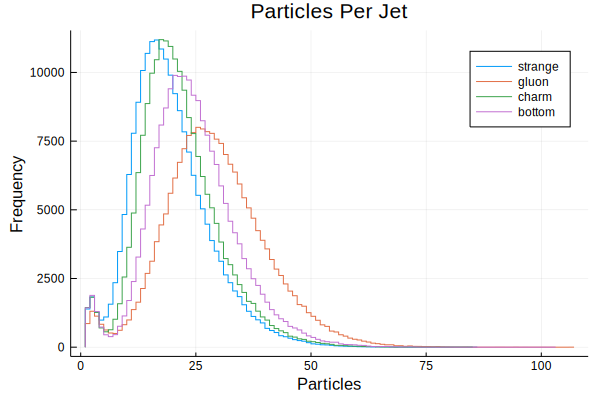

In [90]:
plot([nParticleList,nParticleListgg, nParticleListcc, nParticleListbb], nbins=100,
    seriestype=:stephist, title = "Particles Per Jet", 
    xlabel = "Particles", ylabel = "Frequency", 
    label = ["strange" "gluon" "charm" "bottom"]
    )

In [91]:
# simple histograms - average origin of particles in a jet (H -> ss)
averageorigins = Float64[]
# We are setting up the jet algorithm
# for details, see "A new jet reconstruction algorithm for lepton colliders"
# https://arxiv.org/abs/1404.4294
vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

LCIO.open("E250-TDR_ws.Pe2e2h_ss.Gwhizard-2_82.eR.pL.slcio") do reader
    iEvent = 0
    for event in reader
        iEvent += 1
        iParticle = 0
        iMuon = 0
        particles = PseudoJet[]
        MuonIndices = zMuonIndices(event,10)
        
        for particle in getCollection(event, "MCParticle")
            iParticle += 1
            
            if getGeneratorStatus(particle) != 1 || iParticle in MuonIndices || (abs(getPDG(particle))== 12 || abs(getPDG(particle))==14 || abs(getPDG(particle))==16) 
                continue
            end
            #println(getVertex(particle))
            #println(norm(getVertex(particle)[2]))
            E = getEnergy(particle)
            p = getMomentum(particle)
            #FastJet doesn't operate on LCIO particles, unfortunately. It wants its own input format.
            x = PseudoJet(p[1], p[2], p[3], E)
            FastJet.set_user_index(x, iParticle)
            push!(particles, x)
        end
        # after preparing the input, we can run the tool
        cs = ClusterSequence(StdVector(particles), jet_def)
        # We want 4 jets. Ideally, we'll have one muon from the Z each in two of the jets
        # and particles corresponding to the strange quarks in the other two.
        # This is the lazy way to do the reconstruction.
        # A better way is to find the muons from the Z _first_, and then hand the rest to the jet finder.
        jets = exclusive_jets(cs, 2)
        #push!(nJetList, length(jets))
        for j in jets
            # this is just for demonstration how to figure out what particles are in which jet
            # we have forced the event into four jets, so if we don't get back exactly 4 here, something wrong.
            particleorigins = []
            coll = getCollection(event, "MCParticle")
            maxdisplacements = [0.0, 0.0]
            for x in constituents(j)
                particle = coll[FastJet.user_index(x)]
                origin = norm(getVertex(particle)[2])
                if origin > maxdisplacements[1]
                    maxdisplacements[1] = origin
                elseif origin > maxdisplacements[2]
                    maxdisplacements[2] = origin
                end
                @assert FastJet.n_particles(cs) == length(particles)
            end
            add = (maxdisplacements[1]+ maxdisplacements[2])/2
            if add<201 && add>=1
                push!(averageorigins, add)
            end
        end     
    end
    println("read ", iEvent, " events")
    println(length(averageorigins))
end
count = 0
for x in averageorigins
    if x==0
        count+=1
    end
end
println(count)

read 100000 events
47275
0


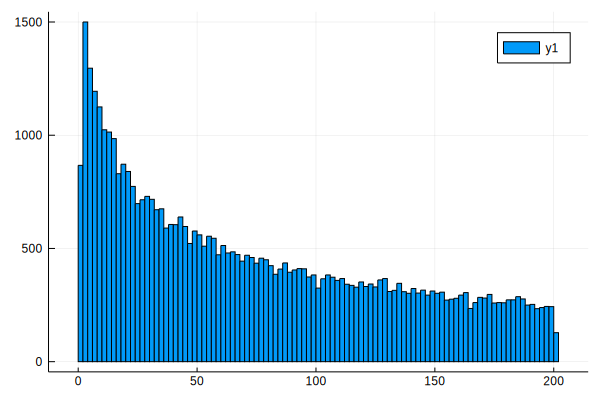

In [92]:
histogram(averageorigins, nbins =100)

In [93]:
# simple histograms - average origin of particles in a jet (H -> cc)
averageoriginscc = Float64[]
# We are setting up the jet algorithm
# for details, see "A new jet reconstruction algorithm for lepton colliders"
# https://arxiv.org/abs/1404.4294
vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

LCIO.open("E250-TDR_ws.Pmumuh2cc.Gwhizard-2_11.eL.pR.slcio") do reader
    iEvent = 0
    for event in reader
        iEvent += 1
        iParticle = 0
        iMuon = 0
        particles = PseudoJet[]
        MuonIndices = zMuonIndices(event,10)
        
        for particle in getCollection(event, "MCParticle")
            iParticle += 1
            
            if getGeneratorStatus(particle) != 1 || iParticle in MuonIndices || (abs(getPDG(particle))== 12 || abs(getPDG(particle))==14 || abs(getPDG(particle))==16) 
                continue
            end
            #println(getVertex(particle))
            #println(norm(getVertex(particle)[2]))
            E = getEnergy(particle)
            p = getMomentum(particle)
            #FastJet doesn't operate on LCIO particles, unfortunately. It wants its own input format.
            x = PseudoJet(p[1], p[2], p[3], E)
            FastJet.set_user_index(x, iParticle)
            push!(particles, x)
        end
        # after preparing the input, we can run the tool
        cs = ClusterSequence(StdVector(particles), jet_def)
        # We want 4 jets. Ideally, we'll have one muon from the Z each in two of the jets
        # and particles corresponding to the strange quarks in the other two.
        # This is the lazy way to do the reconstruction.
        # A better way is to find the muons from the Z _first_, and then hand the rest to the jet finder.
        jets = exclusive_jets(cs, 2)
        #push!(nJetList, length(jets))
        for j in jets
            # this is just for demonstration how to figure out what particles are in which jet
            # we have forced the event into four jets, so if we don't get back exactly 4 here, something wrong.
            particleorigins = []
            coll = getCollection(event, "MCParticle")
            maxdisplacements = [0.0, 0.0]
            for x in constituents(j)
                particle = coll[FastJet.user_index(x)]
                origin = norm(getVertex(particle)[2])
                if origin > maxdisplacements[1]
                    maxdisplacements[1] = origin
                elseif origin > maxdisplacements[2]
                    maxdisplacements[2] = origin
                end
                @assert FastJet.n_particles(cs) == length(particles)
            end
            add = (maxdisplacements[1]+ maxdisplacements[2])/2
            if add<201 && add>=1
                push!(averageoriginscc, add)
            end
        end     
    end
    println("read ", iEvent, " events")
    println(length(averageoriginscc))
end
count = 0
for x in averageoriginscc
    if x==0
        count+=1
    end
end
println(count)

read 100000 events
102565
0


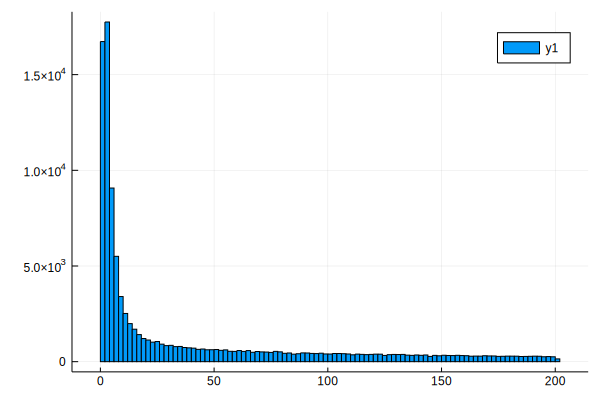

In [94]:
histogram(averageoriginscc, nbins =100)

In [95]:
# simple histograms - average origin of particles in a jet (H -> bb)
averageoriginsbb = Float64[]
# We are setting up the jet algorithm
# for details, see "A new jet reconstruction algorithm for lepton colliders"
# https://arxiv.org/abs/1404.4294
vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

LCIO.open("E250-TDR_ws.Pmumuh2bb.Gwhizard-2_11.eL.pR.slcio") do reader
    iEvent = 0
    for event in reader
        iEvent += 1
        iParticle = 0
        iMuon = 0
        particles = PseudoJet[]
        MuonIndices = zMuonIndices(event,10)
        
        for particle in getCollection(event, "MCParticle")
            iParticle += 1
            
           if getGeneratorStatus(particle) != 1 || iParticle in MuonIndices || (abs(getPDG(particle))== 12 || abs(getPDG(particle))==14 || abs(getPDG(particle))==16) 
                continue
            end
            #println(getVertex(particle))
            #println(norm(getVertex(particle)[2]))
            E = getEnergy(particle)
            p = getMomentum(particle)
            #FastJet doesn't operate on LCIO particles, unfortunately. It wants its own input format.
            x = PseudoJet(p[1], p[2], p[3], E)
            FastJet.set_user_index(x, iParticle)
            push!(particles, x)
        end
        # after preparing the input, we can run the tool
        cs = ClusterSequence(StdVector(particles), jet_def)
        # We want 4 jets. Ideally, we'll have one muon from the Z each in two of the jets
        # and particles corresponding to the strange quarks in the other two.
        # This is the lazy way to do the reconstruction.
        # A better way is to find the muons from the Z _first_, and then hand the rest to the jet finder.
        jets = exclusive_jets(cs, 2)
        #push!(nJetList, length(jets))
        for j in jets
            # this is just for demonstration how to figure out what particles are in which jet
            # we have forced the event into four jets, so if we don't get back exactly 4 here, something wrong.
            particleorigins = []
            coll = getCollection(event, "MCParticle")
            maxdisplacements = [0.0, 0.0]
            for x in constituents(j)
                particle = coll[FastJet.user_index(x)]
                origin = norm(getVertex(particle)[2])
                if origin > maxdisplacements[1]
                    maxdisplacements[1] = origin
                elseif origin > maxdisplacements[2]
                    maxdisplacements[2] = origin
                end
                @assert FastJet.n_particles(cs) == length(particles)
            end
            add = (maxdisplacements[1]+ maxdisplacements[2])/2
            if add<201 && add>=1
                push!(averageoriginsbb, add)
            end
        end     
    end
    println("read ", iEvent, " events")
    println(length(averageoriginsbb))
end
count = 0
for x in averageoriginsbb
    if x==0
        count+=1
    end
end
println(count)

read 100000 events
131648
0


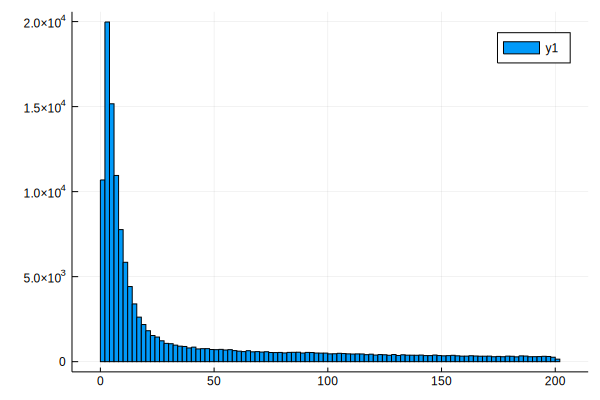

In [96]:
histogram(averageoriginsbb, nbins =100)

In [97]:
# simple histograms - average origin of particles in a jet (H -> gg)
averageoriginsgg = Float64[]
# We are setting up the jet algorithm
# for details, see "A new jet reconstruction algorithm for lepton colliders"
# https://arxiv.org/abs/1404.4294
vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

LCIO.open("E250-TDR_ws.Pmumuh2gg.Gwhizard-2_11.eL.pR.slcio") do reader
    iEvent = 0
    for event in reader
        iEvent += 1
        iParticle = 0
        iMuon = 0
        particles = PseudoJet[]
        MuonIndices = zMuonIndices(event,10)
        
        for particle in getCollection(event, "MCParticle")
            iParticle += 1
            
            if getGeneratorStatus(particle) != 1 || iParticle in MuonIndices || (abs(getPDG(particle))== 12 || abs(getPDG(particle))==14 || abs(getPDG(particle))==16) 
                continue
            end
            #println(getVertex(particle))
            #println(norm(getVertex(particle)[2]))
            E = getEnergy(particle)
            p = getMomentum(particle)
            #FastJet doesn't operate on LCIO particles, unfortunately. It wants its own input format.
            x = PseudoJet(p[1], p[2], p[3], E)
            FastJet.set_user_index(x, iParticle)
            push!(particles, x)
        end
        # after preparing the input, we can run the tool
        cs = ClusterSequence(StdVector(particles), jet_def)
        # We want 4 jets. Ideally, we'll have one muon from the Z each in two of the jets
        # and particles corresponding to the strange quarks in the other two.
        # This is the lazy way to do the reconstruction.
        # A better way is to find the muons from the Z _first_, and then hand the rest to the jet finder.
        jets = exclusive_jets(cs, 2)
        #push!(nJetList, length(jets))
        for j in jets
            # this is just for demonstration how to figure out what particles are in which jet
            # we have forced the event into four jets, so if we don't get back exactly 4 here, something wrong.
            particleorigins = []
            coll = getCollection(event, "MCParticle")
            maxdisplacements = [0.0, 0.0]
            for x in constituents(j)
                particle = coll[FastJet.user_index(x)]
                origin = norm(getVertex(particle)[2])
                if origin > maxdisplacements[1]
                    maxdisplacements[1] = origin
                elseif origin > maxdisplacements[2]
                    maxdisplacements[2] = origin
                end
                @assert FastJet.n_particles(cs) == length(particles)
            end
            add = (maxdisplacements[1]+ maxdisplacements[2])/2
            if add<201 && add>=1
                push!(averageoriginsgg, add)
            end
        end     
    end
    println("read ", iEvent, " events")
    println(length(averageoriginsgg))
end
count = 0
for x in averageoriginsgg
    if x==0
        count+=1
    end
end
println(count)

read 100000 events
74401
0


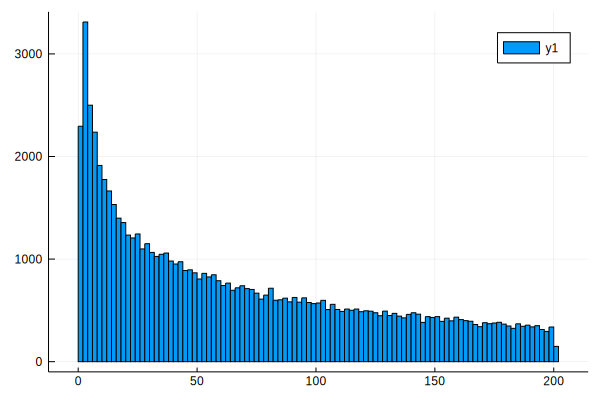

In [98]:
histogram(averageoriginsgg, nbins =100)

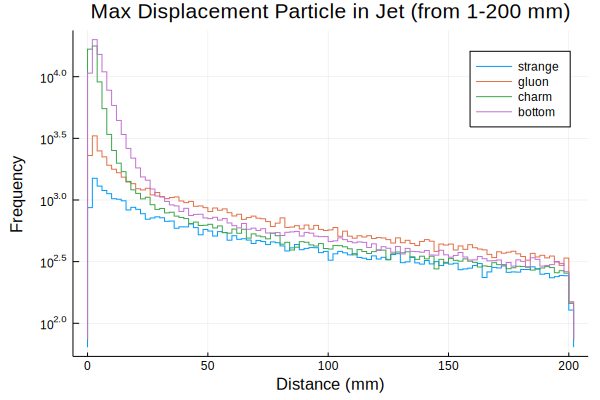

In [99]:
plot([averageorigins,averageoriginsgg, averageoriginscc, averageoriginsbb], nbins=100,
    seriestype=:stephist, title = "Max Displacement Particle in Jet (from 1-200 mm)", yaxis = (:log10),
    xlabel = "Distance (mm)", ylabel = "Frequency", 
    label = ["strange" "gluon" "charm" "bottom"]
    )